# Assignment 1

# Density estimation using Real NVP

Normalizing flows are the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to training a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below. 

<img src="2d-example.png" width=600px>


#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution on $X$ by
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density on a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
\begin{align}
y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big),
\end{align}

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib).
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        x = z
        for mask, t, s in zip(reversed(self.mask), reversed(self.t), reversed(self.s)):
            masked_x = x * mask
            x = masked_x + (1 - mask) * (x - t(masked_x)) * torch.exp(-s(masked_x))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = torch.zeros(list(x.size())[0])
        for mask, t, s in zip(self.mask, self.t, self.s):
            masked_z = z * mask
            s_result = s(masked_z)
            z = masked_z + (1 - mask) * (z * torch.exp(s_result) + t(masked_z))
            log_det_J += torch.sum(s_result * (1 - mask), dim=1)
        
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        return self.prior.log_prob(z) + log_det_J
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        return self.g(prior.sample_n(batchSize))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

DIMENTION = 2
HIDDEN = 128
COUPLING_LAYERS_NUM = 40
NETS_LAYERS_NUM = 5

def make_model(layers_num):
    layers = []
    layers += [
        nn.Linear(DIMENTION, HIDDEN),
        nn.Tanh()
    ]
    for _ in range(layers_num):
        layers += [
            nn.Linear(HIDDEN, HIDDEN),
            nn.Tanh()
        ]
    layers.append(nn.Linear(HIDDEN, DIMENTION))
    return nn.Sequential(*layers)

In [4]:
nets = lambda: make_model(NETS_LAYERS_NUM)  # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = lambda: make_model(NETS_LAYERS_NUM)  # a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
net_s = nets()
net_t = nett()
input_tensor = torch.tensor([[0.1, 0.9]])
assert net_s.forward(input_tensor).shape == torch.Size([1, 2])
assert net_t.forward(input_tensor).shape == torch.Size([1, 2])

In [5]:
import numpy as np
masks = torch.zeros([COUPLING_LAYERS_NUM, DIMENTION]).float() # torch.Tensor of size #number_of_coupling_layers x #dim(X)
masks[slice(0, COUPLING_LAYERS_NUM, 2), 0] = 1
masks[slice(1, COUPLING_LAYERS_NUM, 2), 1] = 1
assert torch.all(torch.sum(masks, dim=1) == 1.0)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [6]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods

In [7]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
print(flow.g(flow.f(input_tensor)[0]))
print(input_tensor)
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

tensor([[0.1000, 0.9000]], grad_fn=<AddBackward0>)
tensor([[0.1000, 0.9000]])


In [8]:
from sklearn import datasets

# list of all trainable parameters in a flow
trainable_parametrs = []
for net in flow.s:
    trainable_parametrs += list(net.parameters())
for net in flow.t:
    trainable_parametrs += list(net.parameters())
l2_reg = torch.tensor(0).float()
reg_lambda = torch.tensor(1).float()
for tensor in trainable_parametrs:
    l2_reg += reg_lambda * torch.norm(tensor)
optimizer = torch.optim.Adam(trainable_parametrs, lr=0.00005)  # choose an optimizer, use module torch.optim
#optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4, weight_decay=1e-5)
#optimizer = torch.optim.LBFGS(trainable_parametrs)  # choose an optimizer, use module torch.optim

def step_closure():
    noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)
    
    # compute the maximum-likelihood loss
    loss = -torch.mean(flow.log_prob(torch.tensor(noisy_circles[0]).float()))
    #loss += l2_reg
    optimizer.zero_grad()
    #loss.backward()
    loss.backward(retain_graph=True)
    return loss

for t in range(15001):
    loss = step_closure()
    optimizer.step()
    #optimizer.step(step_closure)
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.231
iter 500: loss = 1.449
iter 1000: loss = 1.157
iter 1500: loss = 0.868
iter 2000: loss = 0.790
iter 2500: loss = 0.816
iter 3000: loss = 0.696
iter 3500: loss = 0.667
iter 4000: loss = 0.728
iter 4500: loss = 0.795
iter 5000: loss = 0.822
iter 5500: loss = 0.732
iter 6000: loss = 0.708
iter 6500: loss = 0.773
iter 7000: loss = 0.747
iter 7500: loss = 0.649
iter 8000: loss = 0.787
iter 8500: loss = 0.759
iter 9000: loss = 0.606
iter 9500: loss = 0.585
iter 10000: loss = 0.904
iter 10500: loss = 0.707
iter 11000: loss = 0.625
iter 11500: loss = 0.713
iter 12000: loss = 0.781
iter 12500: loss = 0.771
iter 13000: loss = 0.762
iter 13500: loss = 0.728
iter 14000: loss = 0.715
iter 14500: loss = 0.701
iter 15000: loss = 0.753


# Visualization

In [9]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

/Users/icecream/code/venv3/lib/python3.7/site-packages/torch/distributions/distribution.py:133: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


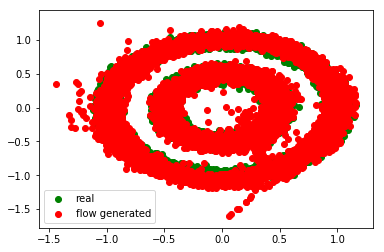

In [10]:
n_samples = 10000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
plt.scatter(noisy_circles[0][:, 0], noisy_circles[0][:, 1], label="real", color="green")
sample = flow.sample(n_samples).detach().numpy()
plt.scatter(sample[:, 0], sample[:, 1], label="flow generated", color="red")
axis = plt.gca()

#prior_sample = flow.prior.sample_n(100)
#plt.scatter(prior_sample[:, 0], prior_sample[:, 1], label="real", color="blue")
axis.legend()

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

## Providde answerrs for the folowing questions:

1. What architecture worked better in your experiments?


**Your answer with justification**


2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


**Your answer with justification**


3. How convergence speed (in iterations) depends on the complexity of architecture?


**Your answer with justification**


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignment.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, than use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.
